In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [2]:
import data_loader
from utils import *
from mcs_function import *
from plotting import *
import config
import pickle
from scipy.optimize import least_squares
import pmcx
import matplotlib.pyplot as plt
from sympy import symbols, dsolve, Function, exp, Eq, oo, limit, Add, Mul, solve, sqrt, log

Check that the solution to the ODE provided by Patterson et. al (1989) gives the diffuse reflectance.

In [3]:
mua, musred = symbols(r"\mu_a \mu_{sg}", positive=True)
k, z, d0 = symbols(r"k z d_0")

In [4]:
musred

\mu_{sg}

In [5]:
theta = Function(r"\theta")(z)
thetap = theta.diff(z)
thetapp = theta.diff(z, 2)

In [6]:
D = 1 / (3*(mua + musred))

In [7]:
eq = Eq(- D*thetapp + mua*theta, musred*exp(-(mua + musred)*z))

In [8]:
eq

Eq(\mu_a*\theta(z) - Derivative(\theta(z), (z, 2))/(3*\mu_a + 3*\mu_{sg}), \mu_{sg}*exp(z*(-\mu_a - \mu_{sg})))

$d_0$ is a temporary variable that describes $\frac{\partial \theta}{\partial z} |_{z=0}$

In [9]:
ics={theta.subs(z, 0): 2*D*k*d0, thetap.subs(z, 0): d0}

In [10]:
res_theta = dsolve(eq, theta, ics=ics)

The result is of the form $$\theta(z) = a\exp(k_1z) + b\exp(k_2 z) + c\exp(k_3 z)$$

Proof:

In [11]:
res_theta.lhs

\theta(z)

In [12]:
assert res_theta.rhs.func == Add
for term in res_theta.rhs.args:
    assert term.func == Mul
    assert all(z not in constant.free_symbols for constant in term.args[:-1])
    print(f"{term.args[-1]}  ---> {limit(term.args[-1], z, oo, '+')}")

exp(sqrt(3)*sqrt(\mu_a)*z*sqrt(\mu_a + \mu_{sg}))  ---> oo
exp(-sqrt(3)*sqrt(\mu_a)*z*sqrt(\mu_a + \mu_{sg}))  ---> 0
exp(-z*(\mu_a + \mu_{sg}))  ---> 0


Result: Only the first term does not go to 0 for $z \rightarrow 0$. To ensure that the entire term goes to zero, the first constant $a$ must be zero.

In [13]:
a = Mul(*res_theta.rhs.args[0].args[:-1])
assert z not in a.free_symbols

In [14]:
res_d0 = solve(Eq(a, 0), d0)

In [15]:
len(res_d0)

1

With newly determined value for $\frac{\partial \theta}{\partial z} |_{z = 0}$, lets solve the ODE again.

In [16]:
ics={theta.subs(z, 0): 2*D*k*res_d0[0], thetap.subs(z, 0): res_d0[0]}

In [17]:
res_theta2 = dsolve(eq, theta, ics=ics)

In [18]:
res_theta2.simplify()

Eq(\theta(z), \mu_{sg}*(sqrt(3)*(2*\mu_a - \mu_{sg})*(8*\mu_a**4*k + 12*\mu_a**4 + 8*\mu_a**3*\mu_{sg}*k + 12*\mu_a**3*\mu_{sg} - 6*\mu_a**2*\mu_{sg}**2*k - 9*\mu_a**2*\mu_{sg}**2 - 4*\mu_a*\mu_{sg}**3*k - 6*\mu_a*\mu_{sg}**3 + 2*\mu_{sg}**4*k + 3*\mu_{sg}**4)*exp(z*(\mu_a + \mu_{sg})) + 3*(-16*\mu_a**(9/2)*k*sqrt(\mu_a + \mu_{sg}) + 8*\mu_a**(7/2)*\mu_{sg}*k*sqrt(\mu_a + \mu_{sg}) + 12*\mu_a**(5/2)*\mu_{sg}**2*k*sqrt(\mu_a + \mu_{sg}) - 10*\mu_a**(3/2)*\mu_{sg}**3*k*sqrt(\mu_a + \mu_{sg}) + 2*sqrt(\mu_a)*\mu_{sg}**4*k*sqrt(\mu_a + \mu_{sg}) - 8*sqrt(3)*\mu_a**5 - 4*sqrt(3)*\mu_a**4*\mu_{sg} + 10*sqrt(3)*\mu_a**3*\mu_{sg}**2 + sqrt(3)*\mu_a**2*\mu_{sg}**3 - 4*sqrt(3)*\mu_a*\mu_{sg}**4 + sqrt(3)*\mu_{sg}**5)*exp(sqrt(3)*sqrt(\mu_a)*z*sqrt(\mu_a + \mu_{sg})))*exp(-z*(sqrt(3)*sqrt(\mu_a)*sqrt(\mu_a + \mu_{sg}) + \mu_a + \mu_{sg}))/((2*\mu_a - \mu_{sg})*(-16*\mu_a**(9/2)*k*sqrt(\mu_a + \mu_{sg}) + 8*\mu_a**(7/2)*\mu_{sg}*k*sqrt(\mu_a + \mu_{sg}) + 12*\mu_a**(5/2)*\mu_{sg}**2*k*sqrt(\mu_a +

Check that $\theta(0)$ equals the expected formula for reflectance.

In [19]:
albedo = musred / (mua + musred)

In [20]:
R_patterson_formula = albedo / (1 + 2*k * (1-albedo) + (1 + 2*k/3) * sqrt(3 * (1 - albedo)))

In [21]:
R_computed_formula = res_theta2.rhs.subs(z, 0) / (2 * k)

In [22]:
(R_computed_formula - R_patterson_formula).simplify() == 0

True

Compare the reflectance formula to Monte Carlo Simulations...

In [23]:
wavelengths = np.arange(520, 900, 30)
mu_a_vals = data_loader.DataLoader.mu_a_func_blood_vessel(wavelengths) / 10
mu_s_red_vals = data_loader.DataLoader.mu_s_red_func_blood_vessel(wavelengths) / 10
g = 0.935
n = 1.4

In [24]:
prop = np.array([[0,0,1,1],[0,0,1.2,1.5]])
vol = np.ones((60, 60, 120), dtype="uint8")

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop": prop,
    "bc": "ccrcca001000",
    "isspecular": 1,
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dpx",
    "flog": str(config.spectra_dir) + "/log.txt",
    #"isnormalized": 0,
    #"issaveref": 1
}

# necessary to accumulate weights, when using issaveref=1
# cfg["vol"][:, :, 0] = 0

R_mcx_vals = []
PL_mcx_vals = []

for i, (mu_a, mu_s_red) in enumerate(zip(mu_a_vals, mu_s_red_vals)):
    cfg["prop"][1, 0] = mu_a
    cfg["prop"][1, 1] = mu_s_red / (1 - g)
    cfg["prop"][1, 2] = g
    cfg["prop"][1, 3] = 1.36
    res = pmcx.mcxlab(cfg)
    detw = pmcx.utils.detweight(res["detp"])
    dref = np.sum(detw) / cfg["nphoton"]
    pl = pmcx.utils.meanpath(res["detp"])[0]
    R_mcx_vals.append(dref)
    PL_mcx_vals.append(pl)


R_mcx_vals = np.array(R_mcx_vals)
PL_mcx_vals = np.array(PL_mcx_vals)

nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
nphoton: 1e+07
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1e+07
issrcfrom0: 1
autopilot: 1
isspecular: 1
n

In [25]:
def R_Patterson(mu_a, mu_s_red, n):
    rd = -1.44 * np.power(n, -2) * 0.71 / n + 0.668 + 0.0636 * n
    k = (1 + rd) / (1 - rd)
    albedo = mu_s_red / (mu_a + mu_s_red)
    return albedo / (1 + 2 * k * (1-albedo) + (1 + 2*k/3)*np.sqrt(3*(1-albedo)))

In [26]:
def R_Carp(mu_a, mu_s, g, n):
    f = g*g
    g_star = g / (1 + g)
    mu_s_star = mu_s * (1 - f)
    mu_t_star = mu_a + mu_s_star
    mu_tr = (mu_a + mu_s * (1-g))
    mu_eff = np.power(3 * mu_a * mu_tr, 1/2)
    h = 2 / (3 * mu_tr)
    A = -0.13755 * np.power(n, 3) + 4.3390 * np.power(n, 2) - 4.90466 * n + 1.6896
    alpha = 3 * mu_s_star * (mu_t_star + g_star * mu_a) / (mu_eff ** 2 - mu_t_star ** 2)
    beta = (-alpha * (1 + A*h*mu_t_star) - 3*A*h*g_star*mu_s_star) / (1 + A*h*mu_eff)
    return (alpha + beta) / (2 * A)

In [27]:
patterson_R = R_Patterson(mu_a_vals, mu_s_red_vals, 1.36)

In [28]:
carp_R = R_Carp(mu_a_vals, mu_s_red_vals / (1 - g), g, 1.36)

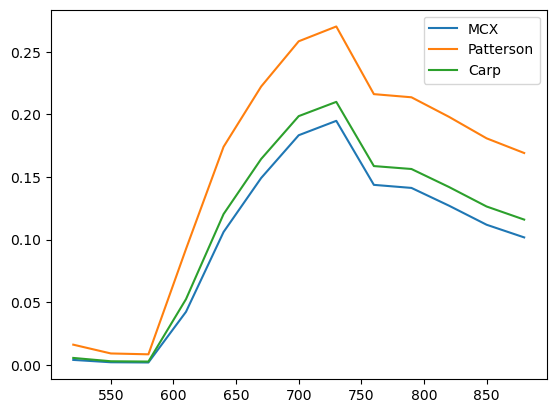

In [29]:
plot_spectra((R_mcx_vals, patterson_R, carp_R), wavelengths, labels=["MCX", "Patterson", "Carp"])

Patterson formula slightly overestimates $R$, Carp's formula very precise.

Compute the derivatives of $A=\log(R)$

In [28]:
A = log(R_patterson_formula)

Derivative to $\mu_a$, i.e. the pathlength:

In [35]:
A.diff(mua).simplify()

(-sqrt(\mu_a)*(\mu_a + \mu_{sg})*(sqrt(3)*sqrt(\mu_a)*(\mu_a + \mu_{sg})*(2*k + 3) + 6*\mu_a*k*sqrt(\mu_a + \mu_{sg}) + 3*(\mu_a + \mu_{sg})**(3/2)) - \mu_{sg}*(12*sqrt(\mu_a)*k*(\mu_a + \mu_{sg})**(3/2) + sqrt(3)*(\mu_a + \mu_{sg})**2*(2*k + 3))/2)/(sqrt(\mu_a)*(\mu_a + \mu_{sg})**2*(sqrt(3)*sqrt(\mu_a)*(\mu_a + \mu_{sg})*(2*k + 3) + 6*\mu_a*k*sqrt(\mu_a + \mu_{sg}) + 3*(\mu_a + \mu_{sg})**(3/2)))

In [37]:
A.diff(musred).simplify()

(-2*sqrt(\mu_a)*\mu_{sg}*(\mu_a + \mu_{sg})**3*(sqrt(3)*sqrt(\mu_a)*(\mu_a + \mu_{sg})*(2*k + 3) + 6*\mu_a*k*sqrt(\mu_a + \mu_{sg}) + 3*(\mu_a + \mu_{sg})**(3/2)) + 2*sqrt(\mu_a)*(\mu_a + \mu_{sg})**4*(sqrt(3)*sqrt(\mu_a)*(\mu_a + \mu_{sg})*(2*k + 3) + 6*\mu_a*k*sqrt(\mu_a + \mu_{sg}) + 3*(\mu_a + \mu_{sg})**(3/2)) + \mu_{sg}*(12*\mu_a**(3/2)*k*(\mu_a + \mu_{sg})**(7/2) + sqrt(3)*\mu_a*(\mu_a + \mu_{sg})**4*(2*k + 3)))/(2*sqrt(\mu_a)*\mu_{sg}*(\mu_a + \mu_{sg})**4*(sqrt(3)*sqrt(\mu_a)*(\mu_a + \mu_{sg})*(2*k + 3) + 6*\mu_a*k*sqrt(\mu_a + \mu_{sg}) + 3*(\mu_a + \mu_{sg})**(3/2)))